**Este notebook tem o objetivo de apresentar uma forma de realizar classificação textual utilizando redes neurais recorrentes (RNN).**

Uma rede neural recorrente (RNN) é uma classe de redes neurais que inclui conexões ponderadas dentro de uma camada (em comparação com as redes de feed-forward tradicionais, onde conecta alimentação apenas para camadas subsequentes). Como as RNNs incluem loops, elas podem armazenar informações ao processar novas entradas. Essa memória os torna ideais para tarefas de processamento onde as entradas anteriores devem ser consideradas (como dados da série temporal).


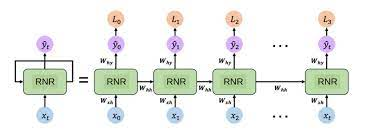





Devido a essa característica de tratar sequências, as RNN se tornam uma ótima opção para tarefas de NLP como tradução, geração de texto ou reconhecimento de fala. 

Outro ponto a ser destacado é a evolução das redes RNN para a utilização de células LSTM (Long-short Term Memory) e posteriormente de células GRU ( Gated Recorrent Unit), consideradas um dos principais motivos para o sucesso das RNN.


Este experimento foi baseado em https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9 .

In [ ]:
# Importação das bibliotecas

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/TopicosNLP-02_2022/Notebooks/Transformes/imdb-reviews-pt-br.csv.zip')

In [ ]:
df_pos=df[df.sentiment=='pos'].sample(5000, random_state=42)
df_neg=df[df.sentiment=='neg'].sample(5000, random_state=42)
df=pd.concat([df_pos,df_neg], ignore_index=True)
df.head()

,id,text_en,text_pt,sentiment
0,38397,This is a very funny movie! I have no idea whe...,Este é um filme muito engraçado! Eu não tenho ...,pos
1,38493,I have just watched the whole 6 episodes on DV...,Acabei de assistir a todos os 6 episódios em D...,pos
2,44531,The material in this documentary is so powerfu...,O material deste documentário é tão poderoso q...,pos
3,40425,Only once in a while do we get an R-rated come...,Apenas de vez em quando recebemos uma comédia ...,pos
4,47654,"Not sure if this counts as a spoiler or not, s...",Não tenho certeza se isso conta como um spoile...,pos


In [ ]:
# Necessário replicar a descrição do sentimento para números inteiros
sentiment_to_code = {'neg':0, 'pos':1}
df.replace({'sentiment': sentiment_to_code}, inplace=True)

In [ ]:
# Separando os dados em treinamento e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text_pt,
                                                    df.sentiment,
                                                    test_size=0.2,
                                                    stratify=df.sentiment,
                                                    random_state=42)

docs=X_train
labels=y_train

In [ ]:
# O primeiro passo do pré-processamento é sempre a decodificação dos tokens
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

In [ ]:
# A segunda etapa é o de padding, etapa que possibilita a redução da 
# dimensionalidade do modelo conforme necessidade

encoded_docs = t.texts_to_sequences(docs)
max_length = 300
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

## Usando uma rede recorrente (RNN) (fonte: https://towardsai.net/p/deep-learning/text-classification-with-rnn)

In [ ]:
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.convolutional import MaxPooling1D

rnnmodel = Sequential()
rnnmodel.add(Embedding(vocab_size, 50, input_length=max_length))
rnnmodel.add(GRU(128, return_sequences=True))
rnnmodel.add(GRU(128))
rnnmodel.add(Dense(1, activation='sigmoid'))

In [ ]:
rnnmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnnmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 50)           2998700   
                                                                 
 gru_2 (GRU)                 (None, 300, 128)          69120     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,167,021
Trainable params: 3,167,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
rnnmodel.fit(padded_docs, labels, epochs=3, verbose=1)

Epoch 1/3
250/250 [==============================] - 166s 652ms/step - loss: 0.6934 - accuracy: 0.5008
Epoch 2/3
250/250 [==============================] - 159s 637ms/step - loss: 0.6628 - accuracy: 0.5548
Epoch 3/3
250/250 [==============================] - 161s 646ms/step - loss: 0.5806 - accuracy: 0.5935


In [ ]:
encoded_docs_test = t.texts_to_sequences(X_test)
max_length = 300
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

loss, accuracy = rnnmodel.evaluate(padded_docs_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 52.550000
